In [1]:
import numpy as np
import pandas as pd
import spiceypy as spy
import datetime
import pandas as pd
import urllib.request
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from astropy import units as u
from astropy.time import TimeDelta, Time
from astropy.coordinates import SkyCoord
from sbpy.data import Ephem
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body, get_moon, SkyCoord
from astroquery.jplsbdb import SBDB #Base de datos del minior planet center de la NASA
from poliastro.bodies import * #Librería diseñada para elaborar graficos interactivos astronómicos basada en ploty
from poliastro.twobody import*
from poliastro.plotting import OrbitPlotter3D
from poliastro.frames import Planes

In [2]:
au = 149597870.693 # [km], fuente: https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/de-403-masses.tpc
mu = 132712440023.31 # [km^3*s^-2] G*M_sol Parámetro gravitacional solar
ae = 23 + 26/60 + 12/3600 # Ángulo de oblicuidad de la elíptica de sexagesimal->decimal
deg = np.pi/180 # parametros que serán utilizado frecuentemente en el códigos
rad = 1/deg 

In [3]:
df_source = pd.read_csv('dr3_source.csv')
df_observation = pd.read_csv('Neas-result.csv')

In [232]:
df_observation


,solution_id,source_id,denomination,transit_id,observation_id,number_mp,epoch,epoch_err,epoch_utc,ra,...,inclination,eccentricity,semi_major_axis,orbital_elements_var_covar_matrix,std_dev_semi_major_axis,h_state_vector,h_state_vector_var_covar_matrix,arc_length,num_observations,time_Utc
0,4428731357481467921,-4284420696,2000 uj1,52376637873742615,523766378737426151,54660,2344.048410,1.137500e-08,2344.047398,225.125032,...,0.814882,0.280962,1.47689,"(2.1156382806642778E-11, 6.569654358326365E-12...",4.599607e-06,"(0.3569412349710894, -1.160720826005859, 0.504...","(1.9034225265376434E-12, 8.755366101878588E-13...",203.690643,105,2016-06-02
1,4428731357481467921,-4284420696,2000 uj1,52376637873742615,523766378737426152,54660,2344.048466,1.137500e-08,2344.047454,225.125033,...,0.814882,0.280962,1.47689,"(2.1156382806642778E-11, 6.569654358326365E-12...",4.599607e-06,"(0.3569412349710894, -1.160720826005859, 0.504...","(1.9034225265376434E-12, 8.755366101878588E-13...",203.690643,105,2016-06-02
2,4428731357481467921,-4284420696,2000 uj1,52376637873742615,523766378737426153,54660,2344.048523,1.137500e-08,2344.047510,225.125036,...,0.814882,0.280962,1.47689,"(2.1156382806642778E-11, 6.569654358326365E-12...",4.599607e-06,"(0.3569412349710894, -1.160720826005859, 0.504...","(1.9034225265376434E-12, 8.755366101878588E-13...",203.690643,105,2016-06-02
3,4428731357481467921,-4284420696,2000 uj1,52376637873742615,523766378737426154,54660,2344.048579,1.137500e-08,2344.047566,225.125036,...,0.814882,0.280962,1.47689,"(2.1156382806642778E-11, 6.569654358326365E-12...",4.599607e-06,"(0.3569412349710894, -1.160720826005859, 0.504...","(1.9034225265376434E-12, 8.755366101878588E-13...",203.690643,105,2016-06-02
4,4428731357481467921,-4284420696,2000 uj1,52376637873742615,523766378737426155,54660,2344.048635,1.137500e-08,2344.047623,225.125012,...,0.814882,0.280962,1.47689,"(2.1156382806642778E-11, 6.569654358326365E-12...",4.599607e-06,"(0.3569412349710894, -1.160720826005859, 0.504...","(1.9034225265376434E-12, 8.755366101878588E-13...",203.690643,105,2016-06-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40219,4428731357481467921,-4284906796,miwablock,71110621979923738,711106219799237385,6050,2682.843202,1.137500e-08,2682.842173,275.882446,...,0.111722,0.436383,2.20350,"(1.5887535398006806E-16, -1.2652681859636982E-...",1.260458e-08,"(-3.096345290456877, -0.6247687720730646, 0.10...","(3.041507790860605E-17, -3.037077942015517E-17...",801.005692,141,2017-05-06
40220,4428731357481467921,-4284906796,miwablock,71110621979923738,711106219799237386,6050,2682.843258,1.137500e-08,2682.842229,275.882437,...,0.111722,0.436383,2.20350,"(1.5887535398006806E-16, -1.2652681859636982E-...",1.260458e-08,"(-3.096345290456877, -0.6247687720730646, 0.10...","(3.041507790860605E-17, -3.037077942015517E-17...",801.005692,141,2017-05-06
40221,4428731357481467921,-4284906796,miwablock,71110621979923738,711106219799237387,6050,2682.843315,1.137500e-08,2682.842285,275.882475,...,0.111722,0.436383,2.20350,"(1.5887535398006806E-16, -1.2652681859636982E-...",1.260458e-08,"(-3.096345290456877, -0.6247687720730646, 0.10...","(3.041507790860605E-17, -3.037077942015517E-17...",801.005692,141,2017-05-06
40222,4428731357481467921,-4284906796,miwablock,71110621979923738,711106219799237388,6050,2682.843371,1.137500e-08,2682.842342,275.882462,...,0.111722,0.436383,2.20350,"(1.5887535398006806E-16, -1.2652681859636982E-...",1.260458e-08,"(-3.096345290456877, -0.6247687720730646, 0.10...","(3.041507790860605E-17, -3.037077942015517E-17...",801.005692,141,2017-05-06


In [5]:
#Filtrando NEA's
filter_1 = df_source[df_source['semi_major_axis']*(1-df_source['eccentricity']) <1.3] 
len(filter_1)
filter_1 

,number_mp,denomination,osc_epoch,mean_anomaly,arg_perihelion,long_asc_node,inclination,eccentricity,semi_major_axis,orbital_elements_var_covar_matrix,std_dev_semi_major_axis,h_state_vector,h_state_vector_var_covar_matrix,arc_length,num_observations
428,54660,2000_uj1,2454.0,-0.911042,2.757168,3.904748,0.814882,0.280962,1.476890,"(2.1156382806642778E-11, 6.569654358326365E-12...",4.599607e-06,"(0.3569412349710894, -1.160720826005859, 0.504...","(1.9034225265376434E-12, 8.755366101878588E-13...",203.690643,105
1081,369452,2010_lg14,2203.0,0.757464,-3.092275,4.735070,0.597018,0.742614,1.045303,"(6.12349754730806E-18, 3.8705877346677014E-17,...",2.474570e-09,"(-0.5313903564357794, -0.5363685056009219, -0....","(1.853325368927122E-15, -2.207908922522188E-16...",975.347371,154
1180,142040,2002_qe15,2324.0,1.821589,2.800414,3.951687,0.492949,0.344486,1.667089,"(9.490335467525804E-18, 2.8214917372871916E-18...",3.080639e-09,"(-1.7380895396477547, 0.6952586098485855, -0.5...","(1.545980359419273E-17, 2.705048377065924E-17,...",716.753951,39
1779,5645,1990_sp,2210.0,-0.544379,0.841171,0.798747,0.235737,0.387247,1.354948,"(1.8022089811645078E-10, 2.1551451084884638E-1...",1.342464e-05,"(0.8864753508371271, 0.4508227425487278, 0.112...","(1.0009486918745838E-12, -5.157306123985879E-1...",169.163432,22
2305,162463,2000_jh5,2306.0,2.490780,-0.115234,1.400104,0.387711,0.238076,1.145483,"(6.434468499931097E-18, 8.351924976207341E-18,...",2.536625e-09,"(-0.8440593497803185, -1.0782040171686096, -0....","(4.6074613986316925E-18, -3.060709054927738E-1...",727.631412,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152816,15745,yuliya,2140.0,-1.076645,2.453297,2.315004,0.251796,0.254948,1.719671,"(3.360566108290319E-17, 4.647386132426635E-17,...",5.797039e-09,"(-1.5822727281489428, -0.16420573058372584, 0....","(1.9515172174888783E-16, -2.826798138400268E-1...",775.661357,156
153102,24445,2000_pm8,2185.0,-2.178955,-2.466393,3.549443,0.416352,0.544932,2.210591,"(2.509228025348082E-16, 3.337849641439861E-17,...",1.584054e-08,"(-0.5137017099327276, -3.1324818404818786, -0....","(8.639454775283089E-17, -1.0282485441056364E-1...",995.153811,129
154172,10165,1995_bl2,2243.0,-0.322096,-0.201683,5.453352,0.417078,0.503750,1.234674,"(7.288630577027443E-18, -2.5665398137261967E-1...",2.699746e-09,"(-0.2824308228213169, -0.4496110462561711, -0....","(2.8145955966356786E-16, -8.063076315986086E-1...",887.046536,58
154303,4055,magellan,2194.0,1.038246,2.694284,2.877175,0.405923,0.326519,1.820192,"(6.2280545040817126E-18, 2.1622876576602194E-1...",2.495607e-09,"(0.9059866063910483, 1.4299470557118148, -0.07...","(2.080649815535087E-17, -2.815134174910887E-18...",746.045549,105


In [6]:
#Para pasar del tiempo UTC de Gaia con el jd=2455197.5 a tiempo en UTC formato Y-M-D 
t=(Time(2455197.5, format='jd') + TimeDelta(df_observation['epoch_utc']*u.d)).iso
tabla=pd.DataFrame(t)
# tabla

In [7]:
# Quitar las horas y dejar sólo año-mes-día
tiempo = pd.to_datetime(t,cache=False)
tiempo = tiempo.strftime('%Y-%m-%d')
tiempo

Index(['2016-06-02', '2016-06-02', '2016-06-02', '2016-06-02', '2016-06-02',
       '2016-06-02', '2016-06-02', '2016-06-02', '2016-06-02', '2016-06-02',
       ...
       '2017-04-21', '2017-04-21', '2017-05-06', '2017-05-06', '2017-05-06',
       '2017-05-06', '2017-05-06', '2017-05-06', '2017-05-06', '2017-05-06'],
      dtype='object', length=40224)

In [8]:
df_observation["time_Utc"]=tiempo

In [9]:
#función para separar valores iguales en una lista nueva, nos permite conocer la cantidad de datos para un cuerpo partícular
l1 = df_observation['number_mp'].tolist()
l2 = filter_1['number_mp'].tolist()
def datos(l1, l2):
    datos = []
    for i in l2:
        coincidencias = []
        for j in l1:
            if j == i:
                 coincidencias.append(i)
        datos.append(coincidencias)
    
    return datos
 
datos=datos(l1, l2)
#datos = [x for x in datos if x != []] #Eliminar listas vacías
#print(datos)

In [10]:
for i in range (len(datos)):
    print(len(datos[i]),datos[i][0])


108 54660
154 369452
39 142040
22 5645
91 162463
245 53435
46 361754
121 26760
99 66146
24 225416
81 5786
92 141765
38 163693
43 31221
131 21088
127 137925
31 68346
149 85804
47 212359
55 2201
184 5751
71 6239
58 183548
56 389694
55 7341
45 66391
32 68031
65 53789
66 52768
142 66008
72 3908
31 1566
78 99935
162 5381
175 5143
37 4179
69 86667
35 5836
159 1917
84 294739
50 85839
211 5587
150 2062
111 111253
29 267337
66 138359
132 54789
50 68267
123 85818
111 369984
278 189630
43 5653
70 106589
176 3752
124 86829
51 27346
56 2368
28 85236
32 66407
32 186822
67 5731
21 162854
38 13651
104 152952
41 90403
104 1620
38 152964
78 171819
113 5332
26 7350
132 137078
37 162142
147 10115
29 275611
38 53319
48 52762
87 12711
116 10150
48 154278
106 138013
26 223456
114 887
92 105140
155 38086
114 7822
118 138127
50 137052
47 7335
24 217013
36 18172
43 87024
52 52387
49 68548
137 3691
45 6611
97 142563
33 140288
78 1980
26 143624
61 42286
57 198856
187 54071
54 96189
28 1981
35 137924
32 333555
102

In [11]:
#agregar columna de tiempo a df_observation
df = df_observation[df_observation["number_mp"]==1917]
df = df.sort_values("time_Utc")
df = df.drop_duplicates(subset=['time_Utc'])
df = df.reset_index(drop=True)
df

,solution_id,source_id,denomination,transit_id,observation_id,number_mp,epoch,epoch_err,epoch_utc,ra,...,inclination,eccentricity,semi_major_axis,orbital_elements_var_covar_matrix,std_dev_semi_major_axis,h_state_vector,h_state_vector_var_covar_matrix,arc_length,num_observations,time_Utc
0,4428731357481467921,-4284948126,cuyo,25713003037889940,257130030378899403,1917,1861.850258,1.137500e-08,1861.849265,7.777397,...,0.417964,0.504309,2.151225,"(5.744507201273166E-17, -2.1899220841024722E-1...",7.579253e-09,"(-3.0211767047082576, -0.044307992061969025, -...","(1.386007194797008E-17, 4.488900310451641E-18,...",764.260157,159,2015-02-05
1,4428731357481467921,-4284948126,cuyo,28516672765618056,285166727656180561,1917,1912.553086,1.137500e-08,1912.552092,56.972531,...,0.417964,0.504309,2.151225,"(5.744507201273166E-17, -2.1899220841024722E-1...",7.579253e-09,"(-3.0211767047082576, -0.044307992061969025, -...","(1.386007194797008E-17, 4.488900310451641E-18,...",764.260157,159,2015-03-28
2,4428731357481467921,-4284948126,cuyo,29093573531947510,290935735319475105,1917,1922.986268,1.137500e-08,1922.985273,65.923547,...,0.417964,0.504309,2.151225,"(5.744507201273166E-17, -2.1899220841024722E-1...",7.579253e-09,"(-3.0211767047082576, -0.044307992061969025, -...","(1.386007194797008E-17, 4.488900310451641E-18,...",764.260157,159,2015-04-07
3,4428731357481467921,-4284948126,cuyo,29111498115158816,291114981151588162,1917,1923.310256,1.137500e-08,1923.309262,66.194882,...,0.417964,0.504309,2.151225,"(5.744507201273166E-17, -2.1899220841024722E-1...",7.579253e-09,"(-3.0211767047082576, -0.044307992061969025, -...","(1.386007194797008E-17, 4.488900310451641E-18,...",764.260157,159,2015-04-08
4,4428731357481467921,-4284948126,cuyo,41388014326431854,413880143264318546,1917,2145.325028,1.137500e-08,2145.324018,181.533754,...,0.417964,0.504309,2.151225,"(5.744507201273166E-17, -2.1899220841024722E-1...",7.579253e-09,"(-3.0211767047082576, -0.044307992061969025, -...","(1.386007194797008E-17, 4.488900310451641E-18,...",764.260157,159,2015-11-16
5,4428731357481467921,-4284948126,cuyo,44119734994486270,441197349944862705,1917,2194.726749,1.137500e-08,2194.725739,192.470705,...,0.417964,0.504309,2.151225,"(5.744507201273166E-17, -2.1899220841024722E-1...",7.579253e-09,"(-3.0211767047082576, -0.044307992061969025, -...","(1.386007194797008E-17, 4.488900310451641E-18,...",764.260157,159,2016-01-04
6,4428731357481467921,-4284948126,cuyo,46067537378435156,460675373784351568,1917,2229.951933,1.137500e-08,2229.950922,193.748370,...,0.417964,0.504309,2.151225,"(5.744507201273166E-17, -2.1899220841024722E-1...",7.579253e-09,"(-3.0211767047082576, -0.044307992061969025, -...","(1.386007194797008E-17, 4.488900310451641E-18,...",764.260157,159,2016-02-08
7,4428731357481467921,-4284948126,cuyo,46071629460857543,460716294608575431,1917,2230.025542,1.137500e-08,2230.024532,193.743386,...,0.417964,0.504309,2.151225,"(5.744507201273166E-17, -2.1899220841024722E-1...",7.579253e-09,"(-3.0211767047082576, -0.044307992061969025, -...","(1.386007194797008E-17, 4.488900310451641E-18,...",764.260157,159,2016-02-09
8,4428731357481467921,-4284948126,cuyo,46652495965123098,466524959651230983,1917,2240.530330,1.137500e-08,2240.529319,192.689748,...,0.417964,0.504309,2.151225,"(5.744507201273166E-17, -2.1899220841024722E-1...",7.579253e-09,"(-3.0211767047082576, -0.044307992061969025, -...","(1.386007194797008E-17, 4.488900310451641E-18,...",764.260157,159,2016-02-19
9,4428731357481467921,-4284948126,cuyo,51369908656841242,513699086568412422,1917,2325.842281,1.137500e-08,2325.841269,177.136001,...,0.417964,0.504309,2.151225,"(5.744507201273166E-17, -2.1899220841024722E-1...",7.579253e-09,"(-3.0211767047082576, -0.044307992061969025, -...","(1.386007194797008E-17, 4.488900310451641E-18,...",764.260157,159,2016-05-14


In [12]:
res = []
for i in range (len(df)):
    for j in range(len(df)):
        for k in range(len(df)):
            fecha1 = df["time_Utc"][i]
            fecha2 = df["time_Utc"][j]
            fecha3 = df["time_Utc"][k]
            resta1 = np.datetime64(fecha1, 'D') - np.datetime64(fecha2,'D')
            resta2 = np.datetime64(fecha1, 'D') - np.datetime64(fecha3,'D')
            resta3 = np.datetime64(fecha2, 'D') - np.datetime64(fecha3,'D')
            if np.abs(resta1)>1 and np.abs(resta2)>1 and np.abs(resta3)>1:
                a = df.iloc[i]
                b = df.iloc[j]
                c = df.iloc[k]
                res.append(a)
                res.append(b)
                res.append(c)

In [13]:
dfz = pd.DataFrame(res)
#df.iloc[2]['x_gaia'],df.iloc[2]["y_gaia"],df.iloc[2]["z_gaia"]

In [14]:
table_1 = []
for n in range(0,len(dfz)//3):  
    Datos = pd.DataFrame(dfz.iloc[np.r_[3*n:3*n+3]])
    table_1.append(Datos.sort_values("time_Utc"))
    
#Eliminar DataFrame repetidos de la lista de DataFrames
duplicate_index = set()
for i in range(0, len(table_1) - 1):
    for j in range(i, len(table_1)):
        if i != j:
            #print(i, j)
            dfi = table_1[i]
            dfj = table_1[j]
            if dfi.equals(dfj):
                duplicate_index.add(j)

Tabla = []
for idx, df in enumerate(table_1):
    if idx not in duplicate_index:
        Tabla.append(table_1[idx])
    


In [15]:
def tiempo_astronomico(fecha):
    spy.furnsh("naif0012.tls")
    tu=spy.str2et(fecha) 
    dt=spy.deltet(tu,"ET") 
    t=tu-dt
    return (t)

def posicion_gaia(P_Gaia):
    P = -np.array(P_Gaia)*au
    return P

def metodo_gauss(alfa,delta,t):
        
      #Vector unitario para la primera observación
    u1 = np.array([np.cos(delta[0]*deg)*np.cos(alfa[0]*deg),np.cos(delta[0]*deg)*np.sin(alfa[0]*deg),np.sin(delta[0]*deg)])
      
      #Vector unitario para la segunda observación
    u2 = np.array([np.cos(delta[1]*deg)*np.cos(alfa[1]*deg),np.cos(delta[1]*deg)* np.sin(alfa[1]*deg),np.sin(delta[1]*deg)])
      
      #Vector unitario para la tercera observación
    u3 = np.array([np.cos(delta[2]*deg)*np.cos(alfa[2]*deg),np.cos(delta[2]*deg)*np.sin(alfa[2]*deg),np.sin(delta[2]*deg)])
    #print("u1=",u1)
    #print ("u2=",u2)
    #print("u3=",u3)
    #print("\n")

      #Coeficientes de Lagrange 
    r2=3*au #Valor arbitrario
      
    f3=1-mu/(2*r2**3)*(t[2]-t[1])**2
    g3=(t[2]-t[1])-mu/(6*r2**3)*(t[2]-t[1])**3
      
    f1=1-mu/(2*r2**3)*(t[0]-t[1])**2
    g1=(t[0]-t[1])-mu/(6*r2**3)*(t[0]-t[1])**3
      
      #Constantes
      
    c1=g3/(f1*g3-f3*g1)
    c3=-g1/(f1*g3-f3*g1)
      
      #Valor de pho2
    rho2=(np.dot(P_Gaia2,np.cross(u1,u3))-c1*np.dot(P_Gaia1,np.cross(u1,u3))-c3*np.dot(P_Gaia3,np.cross(u1,u3)))/np.dot(u2,np.cross(u1,u3))
      
      
      #Ciclo para encontrar el verdadero valor de r2
      
    r2=3*au
    for i in range(30):
        f3=1-mu/(2*r2**3)*(t[2]-t[1])**2
        g3=(t[2]-t[1])-mu/(6*r2**3)*(t[2]-t[1])**3

        f1=1-mu/(2*r2**3)*(t[0]-t[1])**2
        g1=(t[0]-t[1])-mu/(6*r2**3)*(t[0]-t[1])**3

        c1=g3/(f1*g3-f3*g1)
        c3=-g1/(f1*g3-f3*g1)

        rho2=(np.dot(P_Gaia2,np.cross(u1,u3))-c1*np.dot(P_Gaia1,np.cross(u1,u3))-c3*np.dot(P_Gaia3,np.cross(u1,u3)))/np.dot(u2,np.cross(u1,u3))

        r2=(np.linalg.norm(P_Gaia2)**2+rho2**2-2*rho2*np.dot(P_Gaia2,u2))**0.5
        
        #print(r2/au)
    #print("c1=",c1)
    #print("c3=",c3)
    #print("\n")
    #print("rho2=",rho2)
        
      #valores de pho1 y pho3
        
    rho1=(-np.dot(P_Gaia2,np.cross(u2,u3))+c1*np.dot(P_Gaia1,np.cross(u2,u3))+c3*np.dot(P_Gaia3,np.cross(u2,u3)))/(c1*np.dot(u1,np.cross(u2,u3)))
    rho3=(-np.dot(P_Gaia2,np.cross(u2,u1))+c1*np.dot(P_Gaia1,np.cross(u2,u1))+c3*np.dot(P_Gaia3,np.cross(u2,u1)))/(c3*np.dot(u3,np.cross(u2,u1)))
    #print("rho1=",rho1)
    #print("rho3=",rho3)
    #print("\n")
    
      
      #Valor de r1 y r3
    r1=np.sqrt(np.linalg.norm(P_Gaia1)**2+rho1**2-2*rho1*np.dot(P_Gaia1,u1))
    r3=np.sqrt(np.linalg.norm(P_Gaia3)**2+rho3**2-2*rho3*np.dot(P_Gaia3,u3))
      
      
      #Vectores en sus componenetes rectangulares 
      
      #Vectores de posición
    r1vec=(rho1*u1-P_Gaia1)
    r2vec=(rho2*u2-P_Gaia2)
    r3vec=(rho3*u3-P_Gaia3)

      #Vector de velocidad
    v2vec=(-f3*r1vec+f1*r3vec)/(f1*g3-f3*g1)
      #print("Valores de vectores de estado geocentricos",r1vec,r2vec,r3vec,v2vec)
      
    return(r1vec,r2vec,r3vec,v2vec)

def posiciones_ecliptica(ra):
    sx = ra[0]
    sy = ra[1]*np.cos(ae*deg)+ra[2]*np.sin(ae*deg) 
    sz = ra[2]*np.cos(ae*deg)-ra[1]*np.sin(ae*deg)
    return(sx,sy,sz)

def velocidad_ecliptica(va):
    vx = va[0]
    vy = va[1]*np.cos(ae*deg)+va[2]*np.sin(ae*deg) 
    vz = va[2]*np.cos(ae*deg)-va[1]*np.sin(ae*deg)
    return(vx,vy,vz)

def elementos_orbitales(r1,v2):
    h = np.cross(r1,v2)

          #Vector Nodo    
    k = np.array([0,0,1])
    N = np.cross(k,h)

          #Vector excentricidad
    l = np.cross(v2,h)-mu*(r1/np.linalg.norm(r1))
    e = l/mu


          #Inclinación
    i = np.arccos(h[2]/np.linalg.norm(h))*rad

          #Excentricidad
    ex = np.linalg.norm(e)

          #Longitud del nodo
    long_node = np.arccos(N[0]/np.linalg.norm(N))*rad

          #Argumento del perihelio
    D = np.dot(N,e)
    F = np.linalg.norm(N)*ex
    arg_perh = np.arccos(np.linalg.norm(D/F))*rad + 180 #ángulo complementario

          #Anomalia verdadera,
    A = np.dot(e,r2)
    B = ex*np.linalg.norm(r2)
    anom_true = np.arccos(np.linalg.norm(A/B))*rad

          #Semi-eje mayor
          #semi-latus rectum
    q = np.linalg.norm(h**2/mu)/au
    a = q /(1-ex**2)

    return(a,i,ex,long_node,arg_perh,anom_true)

In [250]:
fechaS=[]
datos={
    "a":[],
    "e":[],
    "i":[],
    "long_node":[],
    "arg_perh":[],
    "anom_true":[]    
}

for i in range(len(Tabla)):

    fecha1 = Tabla[i]["time_Utc"].reset_index(drop=True)[0]
    fecha2 = Tabla[i]["time_Utc"].reset_index(drop=True)[1]
    fecha3 = Tabla[i]["time_Utc"].reset_index(drop=True)[2]

    t1=tiempo_astronomico(fecha1)
    t2=tiempo_astronomico(fecha2)
    t3=tiempo_astronomico(fecha3)

    t = [t1,t2,t3]
    Fechasx = [fecha1,fecha2,fecha3]
    #delta_tiempos = [t[0]-t[1],t[1]-t[2]]

    pos1 = Tabla[i]["x_gaia"].reset_index(drop=True)[0],Tabla[i]["y_gaia"].reset_index(drop=True)[0],Tabla[i]["z_gaia"].reset_index(drop=True)[0]
    pos2 = Tabla[i]["x_gaia"].reset_index(drop=True)[1],Tabla[i]["y_gaia"].reset_index(drop=True)[1],Tabla[i]["z_gaia"].reset_index(drop=True)[1]
    pos3 = Tabla[i]["x_gaia"].reset_index(drop=True)[2],Tabla[i]["y_gaia"].reset_index(drop=True)[2],Tabla[i]["z_gaia"].reset_index(drop=True)[2]

    P_Gaia1 = posicion_gaia(pos1)
    P_Gaia2 = posicion_gaia(pos2)
    P_Gaia3 = posicion_gaia(pos3)

    #P_Gaia1,P_Gaia2,P_Gaia3

    alfa = np.array(Tabla[i]["ra"])
    delta = np.array(Tabla[i]["dec"])

    #alfa,delta

    r1vec,r2vec,r3vec,v2vec = metodo_gauss(alfa,delta,t)

    #r1vec,r2vec,r3vec,v2vec

    r1 = posiciones_ecliptica(r1vec)
    r2 = posiciones_ecliptica(r2vec)
    r3 = posiciones_ecliptica(r3vec)

    #r1,r2,r3

    v2 = velocidad_ecliptica(v2vec)

    #v2

    a,i,ex,long_node,arg_perh,anom_true = elementos_orbitales(r1,v2)

    #a,i,ex,omega,w,tetha
    
    #AGREGANDO DATOS ORBITALES AL DICCIONARIO
    #datos["t"].append(delta_tiempos)
    fechaS.append(Fechasx)
    datos["a"].append(a)
    datos["e"].append(ex)
    datos["i"].append(i)
    datos["long_node"].append(long_node)
    datos["arg_perh"].append(arg_perh)
    datos["anom_true"].append(anom_true)


In [251]:
Datos_orbitales=pd.DataFrame(datos)
Datos_orbitales


,a,e,i,long_node,arg_perh,anom_true
0,-0.057892,24.793351,16.229163,40.895248,198.814511,12.197073
1,-0.240313,9.768247,6.189080,69.140212,203.307652,28.776775
2,0.522892,0.777166,14.093094,38.463757,260.351746,88.536174
3,0.909659,0.987593,12.440599,82.468108,222.846793,46.342724
4,0.982484,0.985553,11.399744,85.462527,223.449022,46.358524
...,...,...,...,...,...,...
424,2.328641,0.841465,3.649978,97.319482,269.717455,52.210165
425,2.281218,0.751666,3.544038,96.696093,269.001357,47.648945
426,2.310455,0.749527,3.476646,95.494428,269.162681,48.308054
427,2.377132,0.800203,3.553076,96.319161,269.641932,51.104527


In [18]:
a = Datos_orbitales["a"] #Semieje mayor
e = Datos_orbitales["e"] #Excentricidad
i = Datos_orbitales["i"] #Inclinación
long_node = Datos_orbitales["long_node"] #Longitud del nodo ascendente
arg_perh = Datos_orbitales["arg_perh"] #Argumento del perihelio
anom_true = Datos_orbitales["anom_true"] #Anomalía verdadera
N = int(len(np.array(Datos_orbitales.index)))
NB = 5

In [19]:
mpdb = pd.read_csv('sbdb_query_results.csv')

asteroid_data = mpdb[mpdb['spkid'] ==2001917] 

"""sbdb = SBDB.query('ceres')["orbit"]
a_obj = (sbdb["elements"]["a"])/u.AU
e_obj = (sbdb["elements"]["e"])
i_obj = (sbdb["elements"]["i"])/u.deg
w_obj = (sbdb["elements"]["w"])/u.deg
om_obj = (sbdb["elements"]["om"])/u.deg
ma_obj = (sbdb["elements"]["ma"])/u.deg"""""
#Nombres de cuerpos unsados: 115052 (2003 RD6), Vesta, Szczecin (2007 TY4), Icarus

a_asteroid = np.mean(asteroid_data['a']) #al ser sólo un valor, podemos llamarlo como el promedio
e_asteroid = np.mean(asteroid_data['e'])
i_asteroid = np.mean(asteroid_data['i'])
long_node_asteroid = np.mean(asteroid_data['om']) #Longitud del nodo ascendente
arg_perh_asteroid = np.mean(asteroid_data['w']) #Argumento del perihelio
anom_true_asteroid = np.mean(asteroid_data['ma']) #anomalia verdadera


In [20]:
asteroid_data

,epoch_mjd,a,e,i,om,w,ma,spkid,per_y,sigma_e,sigma_a,sigma_i,sigma_om,sigma_w,sigma_per,full_name
17,59800,2.15,0.5055,23.96,188.29,194.52,144.8,2001917,3.15,2.100000e-08,3.900000e-09,6.600000e-07,0.000001,0.000001,0.000003,1917 Cuyo (1968 AA)


In [21]:
amin = a_asteroid - np.mean(a)
amax = a_asteroid + np.mean(a)

emin = e_asteroid - 1/np.min(e)
emax = e_asteroid + 1/np.min(e)

imin = i_asteroid - np.mean(i)
imax = i_asteroid + np.mean(i)

long_node_min = (np.mean(long_node)-np.max(long_node))/np.mean(long_node)
long_node_max = (np.mean(long_node)+np.max(long_node))/np.mean(long_node)

arg_perh_min = (np.mean(arg_perh)-np.max(arg_perh))/np.mean(arg_perh)
arg_perh_max = (np.mean(arg_perh)+np.max(arg_perh))/np.mean(arg_perh)

anom_true_min = np.mean(anom_true)-np.max(anom_true)
anom_true_max = np.mean(anom_true)+np.max(anom_true)


In [22]:
Datos_orbitales.index,a

(RangeIndex(start=0, stop=429, step=1),
 0     -0.058409
 1     -0.211260
 2      0.518223
 3      0.794406
 4      0.850104
          ...   
 424    1.981338
 425    1.942167
 426    1.968917
 427    2.024352
 428    1.943987
 Name: a, Length: 429, dtype: float64)

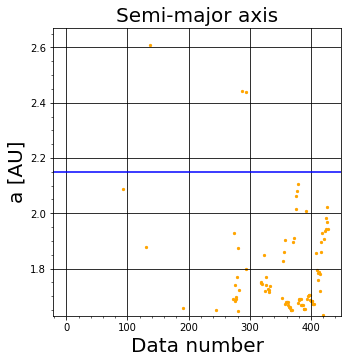

In [23]:
fag = plt.figure(figsize=(4,4))
ax = fag.add_axes([0, 0, 1, 1])
ax.scatter(np.array(Datos_orbitales.index), a, 5, color='orange')
ax.set_ylim(amin, amax)
ax.axhline(y=a_asteroid, xmin=0, xmax=50, color='blue')
ax.set_xlabel('Data number', size=20)
ax.set_ylabel('a [AU]', size=20)
ax.set_title('Semi-major axis', size = 20)
ax.grid(color='black')
ax.minorticks_on()

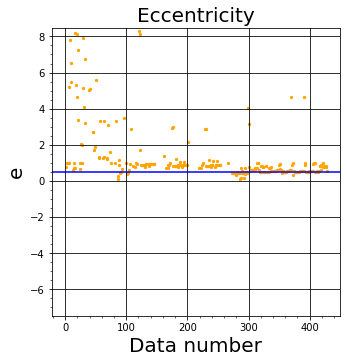

In [24]:
fig = plt.figure(figsize=(4,4))
ex = fig.add_axes([0, 0, 1, 1])
ex.scatter(np.array(Datos_orbitales.index), e, 5, color='orange')
ex.set_ylim(emin, emax)
ex.axhline(y=e_asteroid, xmin=0, xmax=50, color='blue') 
ex.set_xlabel('Data number', size=20)
ex.set_ylabel('e', size=20)
ex.set_title('Eccentricity', size = 20)
ex.grid(color='black')
ex.minorticks_on()

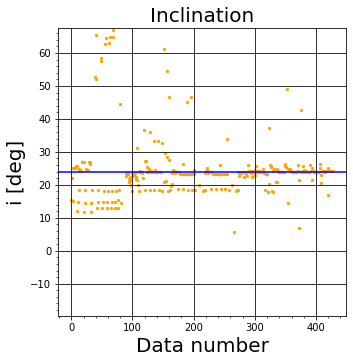

In [25]:
fog = plt.figure(figsize=(4,4))
ix = fog.add_axes([0, 0, 1, 1])
ix.scatter(np.array(Datos_orbitales.index), i, 5, color='orange')
ix.set_ylim(imin, imax)
ix.axhline(y=i_asteroid, xmin=0, xmax=50, color='blue')
ix.set_xlabel('Data number', size=20)
ix.set_ylabel('i [deg]', size=20)
ix.set_title('Inclination', size = 20)
ix.grid(color='black')
ix.minorticks_on()

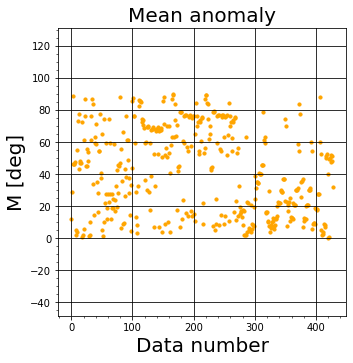

In [26]:
fug = plt.figure(figsize=(4,4))
ox = fug.add_axes([0, 0, 1, 1])
ox.scatter(np.array(Datos_orbitales.index), anom_true, 10, color='orange')
ox.set_ylim(anom_true_min, anom_true_max)
ox.axhline(y=anom_true_asteroid, xmin=0, xmax=50, color='blue')
ox.set_xlabel('Data number', size=20)
ox.set_ylabel('M [deg]', size=20)
ox.set_title('Mean anomaly', size = 20)
ox.grid(color='black')
ox.minorticks_on()

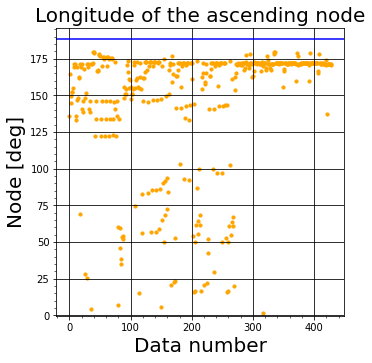

In [27]:
fah = plt.figure(figsize=(4,4))
ux = fah.add_axes([0, 0, 1, 1])
ux.scatter(np.array(Datos_orbitales.index), long_node, 10, color='orange')
#ux.set_ylim(long_node_min, long_node_max)
ux.set_ylim(long_node_min,196)
ux.axhline(y=long_node_asteroid, xmin=0, xmax=50, color='blue')
ux.set_xlabel('Data number', size=20)
ux.set_ylabel('Node [deg]', size=20)
ux.set_title('Longitude of the ascending node', size = 20)
ux.grid(color='black')
ux.minorticks_on()

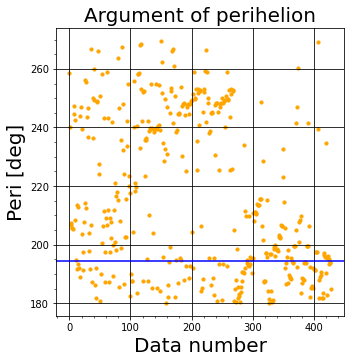

In [28]:
fel = plt.figure(figsize=(4,4))
hx = fel.add_axes([0, 0, 1, 1])
hx.scatter(np.array(Datos_orbitales.index), arg_perh, 10, color='orange')
ox.set_ylim(arg_perh_min, arg_perh_max)
hx.axhline(y= arg_perh_asteroid, xmin=0, xmax=50, color='blue')
hx.set_xlabel('Data number', size=20)
hx.set_ylabel('Peri [deg]', size=20)
hx.set_title('Argument of perihelion', size = 20)
hx.grid(color='black')
hx.minorticks_on()

In [259]:
Datos_orbitales['s'] = np.abs(Datos_orbitales['a'] - a_asteroid)  #semieje mayor
Datos_orbitales['r'] = np.abs(Datos_orbitales['e'] - e_asteroid) # excentricidad
Datos_orbitales['t'] = np.abs(Datos_orbitales['i'] - i_asteroid) # inclinación
Datos_orbitales['u'] = np.abs(Datos_orbitales['long_node'] - long_node_asteroid) # longitud del nodo (depende de la fecha)
Datos_orbitales['v'] = np.abs(Datos_orbitales['arg_perh'] - arg_perh_asteroid) #argumento del perihelio
Datos_orbitales['m'] = np.abs(Datos_orbitales['anom_true'] - anom_true_asteroid) # anomalia verdadera

web1 = np.argmin(Datos_orbitales['s']) 
web2 = np.argmin(Datos_orbitales['r'])
web3 = np.argmin(Datos_orbitales['t'])
web4 = np.argmin(Datos_orbitales['u'])
web5 = np.argmin(Datos_orbitales['v'])
#web6 = np.argmin(Datos_orbitales['m'])


print(np.amin(Datos_orbitales['s']))
print(np.argmin(Datos_orbitales['s']))

print(np.amin(Datos_orbitales['r']))
print(np.argmin(Datos_orbitales['r']))

print(np.amin(Datos_orbitales['t']))
print(np.argmin(Datos_orbitales['t']))

print(np.amin(Datos_orbitales['u']))
print(np.argmin(Datos_orbitales['u']))

print(np.amin(Datos_orbitales['v']))
print(np.argmin(Datos_orbitales['v']))

print(np.amin(Datos_orbitales['m']))
print(np.argmin(Datos_orbitales['m']))


0.00254585693171272
409
0.00012981744312579035
395
1.9807225565816644
352
8.917071773058666
41
1.2877946867068601
335
54.99042212020352
166


In [30]:
Datos_orbitales.sort_values('s')

,a,e,i,long_node,arg_perh,anom_true,s,r,t,u,v,m
378,2.104348,0.479858,24.088767,171.300677,209.650771,36.827797,0.045652,0.025642,0.128767,16.989323,15.130771,107.972203
93,2.088180,0.676001,23.666989,154.158703,215.585981,49.069712,0.061820,0.170501,0.293011,34.131297,21.065981,95.730288
377,2.079984,0.475183,23.967119,171.336793,208.523707,35.722676,0.070016,0.030317,0.007119,16.953207,14.003707,109.077324
376,2.063755,0.472089,23.881828,171.362022,207.740454,34.954942,0.086245,0.033411,0.078172,16.927978,13.220454,109.845058
427,2.024352,0.800203,24.170700,171.347864,193.876800,51.104527,0.125648,0.294703,0.210700,16.942136,0.643200,93.695473
...,...,...,...,...,...,...,...,...,...,...,...,...
82,-14.950265,1.000851,164.978803,45.993529,246.739362,55.412565,17.100265,0.495351,141.018803,142.296471,52.219362,89.387435
314,-44.371685,1.015975,24.867908,166.367267,248.773356,78.668423,46.521685,0.510475,0.907908,21.922733,54.253356,66.131577
100,-92.256881,1.007153,23.707921,155.844213,217.711888,43.934078,94.406881,0.501653,0.252079,32.445787,23.191888,100.865922
407,-98.950379,1.019360,26.213879,165.122292,269.307999,59.779270,101.100379,0.513860,2.253879,23.167708,74.787999,85.020730


In [31]:
#Ordenamiento de 5 elementos orbitales con el menor delta respecto de los valores teóricos.

#Semieje mayor
sort_a = Datos_orbitales.sort_values('a')
df_sort_a  = sort_a.head()
arr_sort_a = np.array(df_sort_a)


#Excentricidad
sort_e = Datos_orbitales.sort_values('e')
df_sort_e  = sort_e.head()
arr_sort_e = np.array(df_sort_e)


#Inclinación
sort_i = Datos_orbitales.sort_values('i')
df_sort_i  = sort_i.head()
arr_sort_i = np.array(df_sort_i)


#Longitud del nodo
sort_long_node = Datos_orbitales.sort_values('long_node')
df_sort_long_node  = sort_long_node.head()
arr_sort_long_node = np.array(df_sort_long_node)


#Argumento del perihelio
sort_arg_perh = Datos_orbitales.sort_values('arg_perh')
df_sort_arg_perh  = sort_arg_perh.head()
arr_sort_arg_perh = np.array(df_sort_arg_perh)

In [32]:
a_ref = np.array(Datos_orbitales[np.argmin(Datos_orbitales['s']):np.argmin(Datos_orbitales['s'])+1])

e_ref = np.array(Datos_orbitales[np.argmin(Datos_orbitales['r']):np.argmin(Datos_orbitales['r'])+1])

i_ref = np.array(Datos_orbitales[np.argmin(Datos_orbitales['t']):np.argmin(Datos_orbitales['t'])+1])

long_node_ref = np.array(Datos_orbitales[np.argmin(Datos_orbitales['u']):np.argmin(Datos_orbitales['u'])+1])

arg_perh_ref = np.array(Datos_orbitales[np.argmin(Datos_orbitales['v']):np.argmin(Datos_orbitales['v'])+1])

anom_true_ref = np.array(Datos_orbitales[np.argmin(Datos_orbitales['m']):np.argmin(Datos_orbitales['m'])+1])

In [33]:
anom_true_ref, a_ref

(array([[-1.21576758e-05,  9.12956189e+04,  1.55650246e+02,
          2.07066944e+01,  2.52310226e+02,  8.98095779e+01,
          2.15001216e+00,  9.12951134e+04,  1.31690246e+02,
          1.67583306e+02,  5.77902261e+01,  5.49904221e+01]]),
 array([[2.10434829e+00, 4.79858163e-01, 2.40887667e+01, 1.71300677e+02,
         2.09650771e+02, 3.68277969e+01, 4.56517085e-02, 2.56418372e-02,
         1.28766680e-01, 1.69893235e+01, 1.51307713e+01, 1.07972203e+02]]))

In [34]:
Datos_orbitales[np.argmin(Datos_orbitales['m']):np.argmin(Datos_orbitales['m'])+1]

,a,e,i,long_node,arg_perh,anom_true,s,r,t,u,v,m
166,-0.000012,91295.618859,155.650246,20.706694,252.310226,89.809578,2.150012,91295.113359,131.690246,167.583306,57.790226,54.990422


In [35]:
asteroid_data

,epoch_mjd,a,e,i,om,w,ma,spkid,per_y,sigma_e,sigma_a,sigma_i,sigma_om,sigma_w,sigma_per,full_name
17,59800,2.15,0.5055,23.96,188.29,194.52,144.8,2001917,3.15,2.100000e-08,3.900000e-09,6.600000e-07,0.000001,0.000001,0.000003,1917 Cuyo (1968 AA)


In [260]:
epoca = Time("2022-08-09", scale="tdb")
epoca1 = Time(f'{fechaS[web1][2]}', scale="tdb")
epoca2 = Time(f'{fechaS[web2][2]}', scale="tdb")
epoca3 = Time(f'{fechaS[web3][2]}', scale="tdb")
epoca4 = Time(f'{fechaS[web4][2]}', scale="tdb")
epoca5 = Time(f'{fechaS[web5][2]}', scale="tdb")

#orbit_JPL1 = Orbit.from_sbdb("Ceres")
orbit_JPL=Orbit.from_classical(attractor= Sun, epoch=epoca, a=asteroid_data.iloc[0,1]*u.au,
                               ecc=asteroid_data.iloc[0,2]*u.one,
                               inc=asteroid_data.iloc[0,3]*u.deg,
                               raan=asteroid_data.iloc[0,4]*u.deg,
                               argp=asteroid_data.iloc[0,5]*u.deg, 
                               nu=asteroid_data.iloc[0,6]*u.deg)
orbita = orbit_JPL.sample(values=1000)/au

Asteroide_1 = Orbit.from_classical(attractor= Sun, epoch=epoca1, 
                                 a = a_ref[0,0]*u.au, ecc= a_ref[0,1]*u.one, inc=a_ref[0,2]*u.deg,
                                 raan=a_ref[0,3]*u.deg, argp=a_ref[0,4]*u.deg, nu=a_ref[0,5]*u.deg)
orbita_1 = Asteroide_1.sample(values=1000)/au

Asteroide_2 = Orbit.from_classical(attractor= Sun, epoch=epoca1, 
                                 a = e_ref[0,0]*u.au, ecc= e_ref[0,1]*u.one, inc=e_ref[0,2]*u.deg,
                                 raan=e_ref[0,3]*u.deg, argp=e_ref[0,4]*u.deg, nu=e_ref[0,5]*u.deg)

Asteroide_3=Orbit.from_classical(attractor= Sun, epoch=epoca1, 
                                 a = i_ref[0,0]*u.au, ecc= i_ref[0,1]*u.one, inc=i_ref[0,2]*u.deg,
                                 raan=i_ref[0,3]*u.deg, argp=i_ref[0,4]*u.deg, nu=i_ref[0,5]*u.deg)

Asteroide_4=Orbit.from_classical(attractor= Sun, epoch=epoca1, 
                                 a = long_node_ref[0,0]*u.au, ecc= long_node_ref[0,1]*u.one, 
                                 inc=long_node_ref[0,2]*u.deg, raan=long_node_ref[0,3]*u.deg,
                                 argp=long_node_ref[0,4]*u.deg, nu=long_node_ref[0,5]*u.deg)

"""Asteroide_5=Orbit.from_classical(attractor= Sun, epoch=epoca1, 
                                 a =arg_perh_ref[0,1]*u.au, ecc= arg_perh_ref[0,2]*u.one,
                                 inc=arg_perh_ref[0,3]*u.deg, raan=arg_perh_ref[0,4]*u.deg,
                                 argp=arg_perh_ref[0,5]*u.deg, nu=arg_perh_ref[0,6]*u.deg)"""




frame = OrbitPlotter3D(unit=u.au) 

figure=frame.plot(orbit_JPL,label=f'{asteroid_data.iloc[0,15]}', color = 'black')
figure=frame.plot(Asteroide_1,label=f'{asteroid_data.iloc[0,15]} data number {web1}')
figure=frame.plot(Asteroide_2,label=f'{asteroid_data.iloc[0,15]} data number {web2}')
figure=frame.plot(Asteroide_3,label=f'{asteroid_data.iloc[0,15]} data number {web3}')
figure=frame.plot(Asteroide_4,label=f'{asteroid_data.iloc[0,15]} data number {web5}')
#figure=frame.plot(Asteroide_5)#label=f'{asteroid_data.iloc[0,0]} {web6} días')
figure.show()


In [270]:
asteroid_data

,epoch_mjd,a,e,i,om,w,ma,spkid,per_y,sigma_e,sigma_a,sigma_i,sigma_om,sigma_w,sigma_per,full_name
17,59800,2.15,0.5055,23.96,188.29,194.52,144.8,2001917,3.15,2.100000e-08,3.900000e-09,6.600000e-07,0.000001,0.000001,0.000003,1917 Cuyo (1968 AA)


In [269]:
Datos_orbitales.iloc[395]

a              2.000990
e              0.505370
i              3.414501
long_node     99.039585
arg_perh     258.693151
anom_true      9.096960
s              0.149010
r              0.000130
t             20.545499
u             89.250415
v             64.173151
m            135.703040
Name: 395, dtype: float64

In [239]:
asteroid_data

,epoch_mjd,a,e,i,om,w,ma,spkid,per_y,sigma_e,sigma_a,sigma_i,sigma_om,sigma_w,sigma_per,full_name
17,59800,2.15,0.5055,23.96,188.29,194.52,144.8,2001917,3.15,2.100000e-08,3.900000e-09,6.600000e-07,0.000001,0.000001,0.000003,1917 Cuyo (1968 AA)


In [38]:
np.sqrt(Asteroide_1.r[0]**2 + Asteroide_1.r[1]**2 + Asteroide_1.r[2]**2 )

<Quantity 1.75072558e+08 km>

In [39]:
tabla_teorica = pd.DataFrame(asteroid_data)

matriz_teorica_a = np.log10(np.full((5), tabla_teorica["a"]))
matriz_teorica_e = np.log10(np.full((5), tabla_teorica["e"]))
matriz_teorica_i = np.log10(np.full((5), tabla_teorica["i"]))
matriz_teorica_long_node = np.log10(np.full((5), tabla_teorica["om"]))
matriz_teorica_arg_perh = np.log10(np.full((5), tabla_teorica["w"]))

"""tabla_final = pd.DataFrame(np.concatenate([arr_sort_e, arr_sort_a, arr_sort_i, arr_sort_long_node, arr_sort_arg_perh]),
                           columns = ['fechas','a','e','i','long_node','arg_perh','mean_anomaly','da','de','di',
                                      'd(long_node)','d(arg_perh)','d(mean_anomaly)'])"""
                                      
tabla_final = pd.DataFrame(np.concatenate([a_ref, e_ref, i_ref, long_node_ref, arg_perh_ref]),
                           columns = ['a','e','i','long_node','arg_perh','mean_anomaly','da','de','di',
                                      'd(long_node)','d(arg_perh)','d(mean_anomaly)'])
                                                                                              
                                                                                            

In [40]:
ordered_a = (tabla_final.sort_values('da')).head()
ordered_e = (tabla_final.sort_values('de')).head()
ordered_i = (tabla_final.sort_values('di')).head()
ordered_long_node = (tabla_final.sort_values('d(long_node)')).head()
ordered_arg_perh = (tabla_final.sort_values('d(arg_perh)')).head()

In [41]:
ordered_a

,a,e,i,long_node,arg_perh,mean_anomaly,da,de,di,d(long_node),d(arg_perh),d(mean_anomaly)
0,2.104348,0.479858,24.088767,171.300677,209.650771,36.827797,0.045652,0.025642,0.128767,16.989323,15.130771,107.972203
1,1.701131,0.505370,24.293285,171.780207,185.249170,9.096960,0.448869,0.000130,0.333285,16.509793,9.270830,135.703040
2,1.653469,0.574879,23.958971,171.716279,199.569045,29.981769,0.496531,0.069379,0.001029,16.573721,5.049045,114.818231
3,1.023871,0.747377,20.799464,179.833829,199.988551,13.691071,1.126129,0.241877,3.160536,8.456171,5.468551,131.108929
4,-0.053134,20.520815,14.751674,136.036720,194.681537,73.023940,2.203134,20.015315,9.208326,52.253280,0.161537,71.776060


In [42]:
# Como la tabla tiene una columan de fechas aplicamos .iloc[:, 1:] para coger solo los valores númericos 
#tabla_nueva = np.log10(np.abs(Datos_orbitales.iloc[:, 1:]))
tabla_nueva = np.log10(np.abs(tabla_final))


In [60]:
tabla_nueva

,a,e,i,long_node,arg_perh,mean_anomaly,da,de,di,d(long_node),d(arg_perh),d(mean_anomaly)
0,0.323118,-0.318887,1.381815,2.233759,2.321496,1.566176,-1.340543,-1.591051,-0.890197,1.230176,1.179861,2.033312
1,0.230738,-0.296390,1.385486,2.234973,2.267756,0.958896,-0.347880,-3.886667,-0.477184,1.217742,0.967119,2.132590
2,0.218396,-0.240423,1.379468,2.234811,2.300093,1.476857,-0.304054,-1.158770,-2.987717,1.219420,0.703209,2.060011
3,0.010245,-0.126460,1.318052,2.254871,2.301005,1.136437,0.051588,-0.616405,0.499761,0.927174,0.737872,2.117632
4,-1.274625,1.312195,1.168841,2.133656,2.289325,1.863465,0.343041,1.301362,0.964181,1.718114,-0.791727,1.855980


In [43]:
from scipy import stats

y = np.array([matriz_teorica_a, matriz_teorica_e, matriz_teorica_i,
     matriz_teorica_long_node, matriz_teorica_arg_perh])

y = y.reshape((25), order='C')    

x = np.array([tabla_nueva['a'],tabla_nueva['e'], tabla_nueva['i'], 
    tabla_nueva['long_node'], tabla_nueva['arg_perh']])

x = x.reshape((25), order='C')  


slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

print(slope, intercept, r_value, p_value, std_err)


0.8588527595382213 0.1981303506510219 0.9065277236864148 4.3745063140035457e-10 0.08339435980293101


In [44]:
import statsmodels.api as sm

#Generate artificial data (2 regressors + constant)


#Fit regression model
results = sm.OLS(y, x).fit()

#Inspect the results
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.916
Model:                            OLS   Adj. R-squared (uncentered):              0.913
Method:                 Least Squares   F-statistic:                              262.6
Date:                Mon, 18 Jul 2022   Prob (F-statistic):                    2.00e-14
Time:                        20:19:10   Log-Likelihood:                         -15.944
No. Observations:                  25   AIC:                                      33.89
Df Residuals:                      24   BIC:                                      35.11
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [45]:
def lineal_function(x):
    return slope*x + intercept 

Y = lineal_function(x)

In [63]:
asteroid_data

,epoch_mjd,a,e,i,om,w,ma,spkid,per_y,sigma_e,sigma_a,sigma_i,sigma_om,sigma_w,sigma_per,full_name
17,59800,2.15,0.5055,23.96,188.29,194.52,144.8,2001917,3.15,2.100000e-08,3.900000e-09,6.600000e-07,0.000001,0.000001,0.000003,1917 Cuyo (1968 AA)


In [91]:
matriz_teorica_e,tabla_nueva['e']

(array([-0.29627884, -0.29627884, -0.29627884, -0.29627884, -0.29627884]),
 0   -0.318887
 1   -0.296390
 2   -0.240423
 3   -0.126460
 4    1.312195
 Name: e, dtype: float64)

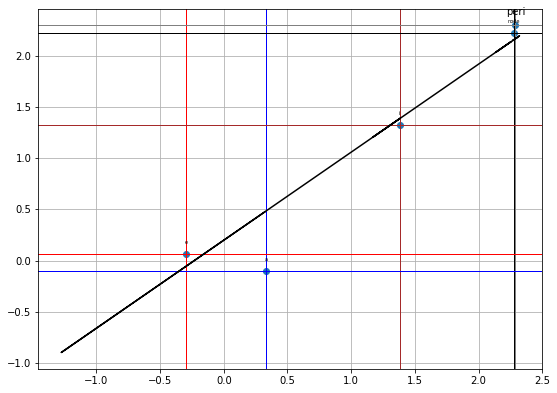

In [231]:
ae, ee, ie, nodee, perie = np.mean(tabla_nueva["a"]), np.mean(tabla_nueva["e"]), np.mean(tabla_nueva["i"]), np.mean(tabla_nueva["long_node"]), np.mean(tabla_nueva["arg_perh"])
a, e, i, node, peri = float(np.log10(asteroid_data["a"])),float(np.log10(asteroid_data["e"])),float(np.log10(asteroid_data["i"])),float(np.log10(asteroid_data["om"])),float(np.log10(asteroid_data["w"]))
#ae, ee, ie, nodee, perie = tabla_nueva['e'],tabla_nueva['a'], tabla_nueva['i'],tabla_nueva['long_node'], tabla_nueva['arg_perh']

#a, e, i, node, peri = matriz_teorica_e, matriz_teorica_a, matriz_teorica_i, matriz_teorica_long_node, matriz_teorica_arg_perh

figuring = plt.figure(figsize=(7,5))
jx = figuring.add_axes([0,0,1,1])


jx.scatter([a,e,i,node,peri], [ae,ee,ie,nodee,perie])

jx.axvline(a, color = 'blue', label = 'theoretical a', lw = 1)
jx.axvline(e, color = 'red', label = 'theoretical e', lw = 1)
jx.axvline(i, color = 'brown', label = 'theoretical i', lw = 1)
jx.axvline(node, color = 'black', label = 'theoretical node', lw = 1)
jx.axvline(peri, color = 'gray', label = 'theoretical peri', lw = 1)

jx.axhline(ae, color = 'blue', label = 'exp a', lw = 1)
jx.axhline(ee, color = 'red', label = 'exp e', lw = 1)
jx.axhline(ie, color = 'brown', label = 'exp i', lw = 1)
jx.axhline(nodee, color = 'black', label = 'exp node', lw = 1)
jx.axhline(perie, color = 'gray', label = 'exp peri', lw = 1)
jx.plot(x,Y, color = 'black')

jx.annotate('a', # this is the text
                 (a,ae), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', size = 5)

jx.annotate('e', # this is the text
                 (e,ee), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', size = 5)

jx.annotate('i', # this is the text
                 (i,ie), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', size = 5)

jx.annotate('node', # this is the text
                 (node,nodee), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', size = 5)

jx.annotate('peri', # this is the text
                 (peri,perie), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', size = 10)

jx.grid()


Text(0.5, 1.0, 'Lineal squares minimum aproximation')

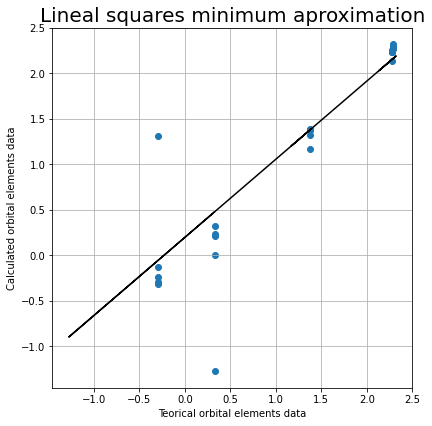

In [93]:
fig = plt.figure(figsize=(7,5))
ejes = fig.add_axes([0,0,1,1])
ejes.scatter([matriz_teorica_e, matriz_teorica_a, matriz_teorica_i,
             matriz_teorica_long_node, matriz_teorica_arg_perh],
            [tabla_nueva['e'],tabla_nueva['a'], tabla_nueva['i'], 
            tabla_nueva['long_node'], tabla_nueva['arg_perh']])
plt.grid()
fig.set_size_inches(5, 5)
ejes.plot(x,Y, color = 'black')
ejes.set_xlabel('Teorical orbital elements data', size = 10)
ejes.set_ylabel('Calculated orbital elements data', size = 10)
ejes.set_title('Lineal squares minimum aproximation', size = 20)

In [98]:
#NA = np.full(N, tabla_teorica["a"])
#axis_major = Datos_orbitales["a"]
magnitudes_ter = []
magnitudes_exp = []
x_ter = []
x_exp = []
y_ter = []
y_exp = []
z_ter = []
z_exp = []
for k in range (len(orbita)):
    mag_or = orbita[k].x/u.km,orbita[k].y/u.km,orbita[k].z/u.km
    mag_or1 = orbita_1[k].x/u.km,orbita_1[k].y/u.km,orbita_1[k].z/u.km
    
    magnitudes_ter.append(np.linalg.norm(mag_or))
    magnitudes_exp.append(np.linalg.norm(mag_or1))
    
    x_ter.append(mag_or[0]) 
    x_exp.append(mag_or1[0])      
    
    y_ter.append(mag_or[1]) 
    y_exp.append(mag_or1[1])  
    
    z_ter.append(mag_or[2]) 
    z_exp.append(mag_or1[2]) 

In [48]:
tabla_corr = {'a_corr':tabla_final['a']*(slope+intercept), 'e_corr':tabla_final['e']*(slope+intercept),
             'i_corr':tabla_final['i']*(slope+intercept), 'long_node_corr':tabla_final['long_node']*(slope+intercept),
             'arg_perh_corr':tabla_final['arg_perh']*(slope+intercept)}
             
tabla_corr = pd.DataFrame(tabla_corr)
tabla_corr



,a_corr,e_corr,i_corr,long_node_corr,arg_perh_corr
0,2.224261,0.507202,25.461420,181.061922,221.597324
1,1.798066,0.534168,25.677592,181.568777,195.805244
2,1.747689,0.607638,25.324228,181.501207,210.941110
3,1.082214,0.789965,21.984682,190.081320,211.384520
4,-0.056162,21.690154,15.592271,143.788515,205.775097


In [49]:
tabla_final

,a,e,i,long_node,arg_perh,mean_anomaly,da,de,di,d(long_node),d(arg_perh),d(mean_anomaly)
0,2.104348,0.479858,24.088767,171.300677,209.650771,36.827797,0.045652,0.025642,0.128767,16.989323,15.130771,107.972203
1,1.701131,0.505370,24.293285,171.780207,185.249170,9.096960,0.448869,0.000130,0.333285,16.509793,9.270830,135.703040
2,1.653469,0.574879,23.958971,171.716279,199.569045,29.981769,0.496531,0.069379,0.001029,16.573721,5.049045,114.818231
3,1.023871,0.747377,20.799464,179.833829,199.988551,13.691071,1.126129,0.241877,3.160536,8.456171,5.468551,131.108929
4,-0.053134,20.520815,14.751674,136.036720,194.681537,73.023940,2.203134,20.015315,9.208326,52.253280,0.161537,71.776060


In [50]:
tabla_corr['d(a_corr)'] = np.abs(tabla_corr['a_corr'] - float(asteroid_data['a']))
tabla_corr['d(e_corr)'] = np.abs(tabla_corr['e_corr']- float(asteroid_data['e']))
tabla_corr['d(i_corr)'] = np.abs(tabla_corr['i_corr']- float(asteroid_data['i']))
tabla_corr['d(long_node_corr)'] = np.abs(tabla_corr['long_node_corr'] - float(asteroid_data['om']))
tabla_corr['d(arg_perh_corr)'] = np.abs(tabla_corr['arg_perh_corr'] - float(asteroid_data['w']))


In [51]:
corr_respect_e_df = (tabla_corr.sort_values('d(a_corr)')).head()
corr_respect_e_arr = np.array((tabla_corr.sort_values('d(a_corr)')).head())

corr_respect_e_df

,a_corr,e_corr,i_corr,long_node_corr,arg_perh_corr,d(a_corr),d(e_corr),d(i_corr),d(long_node_corr),d(arg_perh_corr)
0,2.224261,0.507202,25.461420,181.061922,221.597324,0.074261,0.001702,1.501420,7.228078,27.077324
1,1.798066,0.534168,25.677592,181.568777,195.805244,0.351934,0.028668,1.717592,6.721223,1.285244
2,1.747689,0.607638,25.324228,181.501207,210.941110,0.402311,0.102138,1.364228,6.788793,16.421110
3,1.082214,0.789965,21.984682,190.081320,211.384520,1.067786,0.284465,1.975318,1.791320,16.864520
4,-0.056162,21.690154,15.592271,143.788515,205.775097,2.206162,21.184654,8.367729,44.501485,11.255097


In [52]:
obs_days = corr_respect_e_df.index.values #extraer nombres de las filas 
obs_days

array([0, 1, 2, 3, 4], dtype=int64)

In [53]:
(tabla_final.sort_values('da')).head()

,a,e,i,long_node,arg_perh,mean_anomaly,da,de,di,d(long_node),d(arg_perh),d(mean_anomaly)
0,2.104348,0.479858,24.088767,171.300677,209.650771,36.827797,0.045652,0.025642,0.128767,16.989323,15.130771,107.972203
1,1.701131,0.505370,24.293285,171.780207,185.249170,9.096960,0.448869,0.000130,0.333285,16.509793,9.270830,135.703040
2,1.653469,0.574879,23.958971,171.716279,199.569045,29.981769,0.496531,0.069379,0.001029,16.573721,5.049045,114.818231
3,1.023871,0.747377,20.799464,179.833829,199.988551,13.691071,1.126129,0.241877,3.160536,8.456171,5.468551,131.108929
4,-0.053134,20.520815,14.751674,136.036720,194.681537,73.023940,2.203134,20.015315,9.208326,52.253280,0.161537,71.776060


In [57]:
def mse(magnitudes_exp, magnitudes_ter): 
    #axis_major, NA = np.array(axis_major), np.array(NA)
    resultado = np.square(np.subtract(magnitudes_exp,magnitudes_ter)).mean()
    resultado = np.sqrt(resultado)
    return resultado

resultado = mse(magnitudes_exp, magnitudes_ter)
resultado =resultado/np.sqrt(len(magnitudes_ter))
resultado
#97.66277064016862/np.sqrt(430),resultado

0.035907152041390285

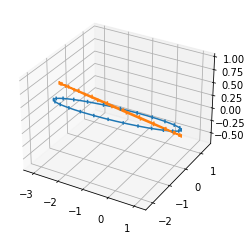

In [188]:
ax = plt.figure().add_subplot(projection='3d')
estep = 40

ax.errorbar(x_ter, y_ter, z_ter,errorevery=estep)
ax.errorbar(x_exp, y_exp, z_exp,resultado,errorevery=estep)
plt.show()

In [121]:
import plotly.graph_objs as go


In [225]:
fig = go.Figure(data=[go.Scatter3d(x=np.array(x_ter), y=np.array(y_ter), z=np.array(z_ter),
                                   mode='markers',name='Theoretical orbit',marker=dict(size=1))])

fig.add_scatter3d(x=np.array(x_exp), y=np.array(y_exp), z=np.array(z_exp),mode='markers',name='Approximate orbit',
                  error_x=dict(type='constant',value=0.03,color='purple'),error_z=dict(type='constant',value=0.03,color='purple'),
        marker=dict(size=1))

fig.show()                                  
    


In [56]:
"""epoca = Time("2022-01-21 00:00:00", scale="tdb")
epoca1 = Time("2020-01-23 00:00:00", scale="tdb")
epoca2 = Time("2020-01-25 00:00:00", scale="tdb")
epoca3 = Time("2020-02-04 00:00:00", scale="tdb")
epoca4 = Time("2020-02-06 00:00:00", scale="tdb")
epoca5 = Time("2020-02-20 00:00:00", scale="tdb")

#orbit_JPL1 = Orbit.from_sbdb("Ceres")
orbit_JPL=Orbit.from_classical(attractor= Sun, epoch=epoca, a=asteroid_data.iloc[0,1]*u.au,
                               ecc=asteroid_data.iloc[0,2]*u.one,
                               inc=asteroid_data.iloc[0,3]*u.deg,
                               raan=asteroid_data.iloc[0,4]*u.deg,
                               argp=asteroid_data.iloc[0,5]*u.deg, 
                               nu=asteroid_data.iloc[0,6]*u.deg)
print(orbit_JPL.sample()/au)

Asteroide_11=Orbit.from_classical(attractor= Sun, epoch=epoca1, 
                                 a = corr_respect_e_arr[0,0]*u.au, ecc= corr_respect_e_arr[0,1]*u.one, inc=corr_respect_e_arr[0,2]*u.deg,
                                 raan=corr_respect_e_arr[0,3]*u.deg, argp=corr_respect_e_arr[0,4]*u.deg, nu=corr_respect_e_arr[0,5]*u.deg)


Asteroide_12=Orbit.from_classical(attractor= Sun, epoch=epoca1, 
                                 a = corr_respect_e_arr[1,0]*u.au, ecc= corr_respect_e_arr[1,1]*u.one, inc=corr_respect_e_arr[1,2]*u.deg,
                                 raan=corr_respect_e_arr[1,3]*u.deg, argp=corr_respect_e_arr[1,4]*u.deg, nu=corr_respect_e_arr[1,5]*u.deg)


Asteroide_13=Orbit.from_classical(attractor= Sun, epoch=epoca1, 
                                 a = corr_respect_e_arr[2,0]*u.au, ecc= corr_respect_e_arr[2,1]*u.one, inc=corr_respect_e_arr[2,2]*u.deg,
                                 raan=corr_respect_e_arr[2,3]*u.deg, argp=corr_respect_e_arr[2,4]*u.deg, nu=corr_respect_e_arr[2,5]*u.deg)


Asteroide_14=Orbit.from_classical(attractor= Sun, epoch=epoca1, 
                                 a = corr_respect_e_arr[3,0]*u.au, ecc= corr_respect_e_arr[3,1]*u.one, inc=corr_respect_e_arr[3,2]*u.deg,
                                 raan=corr_respect_e_arr[3,3]*u.deg, argp=corr_respect_e_arr[3,4]*u.deg, nu=corr_respect_e_arr[3,5]*u.deg)


Asteroide_15=Orbit.from_classical(attractor= Sun, epoch=epoca1, 
                                 a = corr_respect_e_arr[4,0]*u.au, ecc= corr_respect_e_arr[4,1]*u.one, inc=corr_respect_e_arr[4,2]*u.deg,
                                 raan=corr_respect_e_arr[4,3]*u.deg, argp=corr_respect_e_arr[4,4]*u.deg, nu=corr_respect_e_arr[4,5]*u.deg)"""






"""frame = OrbitPlotter3D(unit=u.au) 
#figure=frame.plot(orbit_JPL1,label="Ceres");
figure=frame.plot(orbit_JPL,label=f'{asteroid_data.iloc[0,0]}', color = 'black')"""

"""figure=frame.plot(Asteroide_11,label=f'{asteroid_data.iloc[0,0]}{obs_days[0]} días')
figure=frame.plot(Asteroide_12,label=f'{asteroid_data.iloc[0,0]} {obs_days[1]} días')
figure=frame.plot(Asteroide_13,label=f'{asteroid_data.iloc[0,0]} {obs_days[2]} días')
figure=frame.plot(Asteroide_14,label=f'{asteroid_data.iloc[0,0]} {obs_days[3]} días')
#figure=frame.plot(Asteroide_15,label=f'{asteroid_data.iloc[0,0]} {obs_days[4]} días')
figure.show()"""

"figure=frame.plot(Asteroide_11,label=f'{asteroid_data.iloc[0,0]}{obs_days[0]} días')\nfigure=frame.plot(Asteroide_12,label=f'{asteroid_data.iloc[0,0]} {obs_days[1]} días')\nfigure=frame.plot(Asteroide_13,label=f'{asteroid_data.iloc[0,0]} {obs_days[2]} días')\nfigure=frame.plot(Asteroide_14,label=f'{asteroid_data.iloc[0,0]} {obs_days[3]} días')\n#figure=frame.plot(Asteroide_15,label=f'{asteroid_data.iloc[0,0]} {obs_days[4]} días')\nfigure.show()"